In [ ]:
!nvidia-smi

In [ ]:
#%pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12
#%pip install cucim-cu12 cupy-cuda12x

In [ ]:
%pip install fastparquet

In [ ]:
#%load_ext cudf.pandas

# To desable GPU usage
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#from cucim.skimage.exposure import rescale_intensity
import tensorflow as tf
#import cupy as cp
#import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
import gc

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # memory limit 16GB (16 * 1024 MB = 16384 MB) 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16384)] 
        )
        print("Set GPU memory limit to 16GB.")
    except RuntimeError as e:
        print("Error setting memory limit:", e)
else:
    print("No GPUs available.")

#print("Is torch using cuda? ",torch.cuda.is_available())
print("Is tensorflow using cuda? ",tf.test.is_built_with_cuda())
print("Is pandas using cuda? ",pd)


In [ ]:
name_mapping = [
    "box",
    "circularTorus",
    "cone",
    "coneOffset",
    "cylinder",
    "cylinderSlope",
    "dish",
    "mesh",
    "pyramid",
    "rectangularTorus",
    "sphere"
]

In [ ]:
def sort_by_number(texts:list[str]):
    def key(text:str):
        text = re.sub(r'.*photos_', '', text)
        text = re.sub(r'\.csv', '', text)
        text = re.sub(r'\D', '', text)
        return int(text)
    return sorted(texts, key=key)

In [ ]:
!ls /home/workspace

In [ ]:
num_classes = 11
def filter_invalid_labels(image, label):
    # Exclude labels that are less than 0 or greater than the maximum allowed class
    valid_labels = tf.reduce_all(label >= 0) & tf.reduce_all(label < num_classes)
    return valid_labels

In [ ]:
base_path = '/home/workspace/geometry-classifier/data/'

def parse_tfrecord(example_proto):
    """Parse a single TFRecord example."""
    feature_description = {
        'name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    name = tf.io.decode_raw(parsed_example['name'], tf.float32)
    image = tf.io.decode_raw(parsed_example['image'], tf.float32)
    image = tf.reshape(image, (224, 224, 1))  # Reshape image data to 224x224x3
    class_label = tf.cast(name[0], tf.int32)  # Use the first byte as a class label
    return image, class_label

def load_tfrecord(tfrecord_files):
    """Load TFRecords and prepare a dataset."""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type="GZIP")
    parsed_dataset = raw_dataset.map(parse_tfrecord)
    return parsed_dataset

# Directory with TFRecords

files_for = lambda file_type: glob.glob(f"{base_path}/tfrecord/{file_type}*.tfrecord.gz")

test_files = files_for("test")
validation_files = files_for("val")
train_files = files_for("train")

print(glob.glob(f"{base_path}tfrecord/*.tfrecord.gz")[0])

test = load_tfrecord(test_files).filter(filter_invalid_labels)
test = test.batch(32).prefetch(tf.data.AUTOTUNE)

validation = load_tfrecord(validation_files).filter(filter_invalid_labels)
validation = validation.batch(32).prefetch(tf.data.AUTOTUNE)

train = load_tfrecord(train_files).filter(filter_invalid_labels)
train = train.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# 224 x 224

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', input_shape=(224,224,1)),
    layers.MaxPooling2D((2, 2)),
    

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    

    layers.Flatten(),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(11, activation='softmax') 
])

model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
checkpoint_callback = ModelCheckpoint(base_path+'model2.keras',save_best_only=True, save_weights_only=False, mode='min', verbose=1)
early_stopping = EarlyStopping(
    monitor="val_loss",       # Monitor validation loss
    patience=5,               # Wait for 5 epochs without improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)

epochs = 100
steps_in_total = (1024 * 812 * 60)//100

In [23]:

cnn = model.fit(train, epochs=epochs,callbacks=[
    early_stopping,
    checkpoint_callback
], validation_data=validation)

15605/15607 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9988 - loss: 0.0037

2024-11-17 18:33:29.780645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7522895770734502708
2024-11-17 18:33:29.780733: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7582625166009220788



Epoch 17: val_loss did not improve from 0.01428
15607/15607 ━━━━━━━━━━━━━━━━━━━━ 607s 39ms/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.9986 - val_loss: 0.0151
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.


2024-11-17 18:35:49.565226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7522895770734502708
2024-11-17 18:35:49.565346: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7582625166009220788


In [24]:
test_loss, test_accuracy = model.evaluate(test)
test_loss, test_accuracy

5184/5184 ━━━━━━━━━━━━━━━━━━━━ 142s 27ms/step - accuracy: 0.9991 - loss: 0.0049


2024-11-17 20:48:30.062421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7522895770734502708
2024-11-17 20:48:30.062534: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7582625166009220788


(0.015483572147786617, 0.9984809160232544)

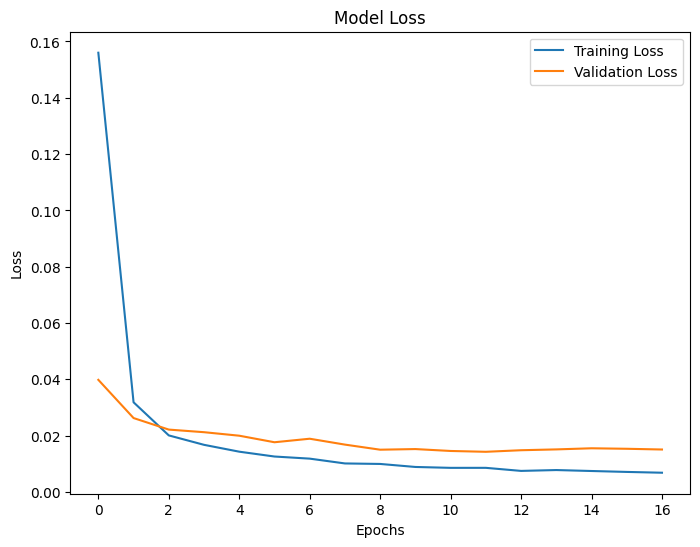

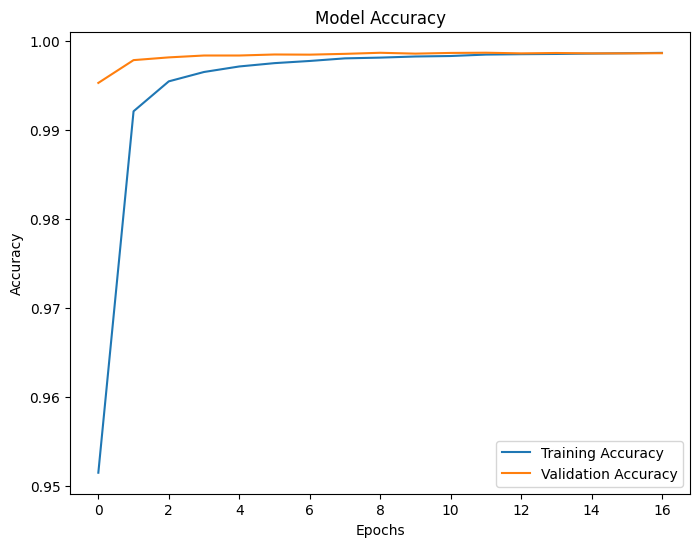

In [25]:
history = cnn

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()